Trabalho 2 - SME0823 Modelos de Regressão e Aprendizado Supervisionado II<br>
Gustavo Terra Brandão da Silva - NUSP:11274935<br>
Olavo Morais Borges Pereira - NUSP:11297792


# **Introdução**

Para a elaboração deste trabalho, optamos por abordar um problema de classificação binária utilizando dados provenientes do repositório UCI. O conjunto de dados consiste em 768 pacientes do sexo feminino, todos com mais de 21 anos e pertencentes à etnia indígena Pima, localizados no estado do Arizona, Estados Unidos.<br><br> As pacientes foram categorizadas em dois grupos: saudáveis e portadoras de diabetes. As informações foram obtidas do UCI/Kaggle e estão disponíveis através do seguinte link: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database/code?datasetId=228&searchQuery=logistic.

<br>Cada paciente é caracterizado por oito features/variáveis explicativas, são elas:

*   Pregnancies: Número de vezes que a paciente ficou grávida
*   Glucose: Concentração de glicose no plasma às 2 horas em um teste de tolerância à glicose oral
*   BloodPressure: Pressão arterial diastólica em mm Hg
*   SkinThickness: espessura da dobra cutânea do tríceps (mm)
*   Insulin: Insulina sérica após 2 horas (mu U/ml)
*   BMI: Índice de Massa Corporal (peso em kg/(altura em m)^2)
*   DiabetesPedigreeFunction: Função de pedigree de diabetes, número associado a pré-disposição genética do indivíduo contrair a doença
*   Age: idade(anos)

Além disso, cada paciente possui o target/variável dependente chamada Outcome.<br> Outcome=0 indica uma paciente saudável, Outcome=1 indica uma paciente portadora de diabetes


Para abordar o problema, optamos por empregar a Regressão Logística, ou seja, um Modelo Linear Generalizado (GLM) com a função Logit como função de ligação e a distribuição de Bernoulli como Componente Aleatório.

O primeiro passo é importar os dados e em seguida, visualizar a relação entre cada feature e o Outcome bem como calcular o Valor da Informação de cada feature e verificar se é possível simplificar o dataset.

In [ ]:
#Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from IPython.display import display

In [ ]:
# Crie o DataFrame a partir do CSV
dataframe = pd.read_csv('diabetes.csv')
dataframe
print("\n")

Em primeiro lugar, convém verificar se o dataset está balanceado:

Número de amostras de cada classe:
0    500
1    268
Name: Outcome, dtype: int64




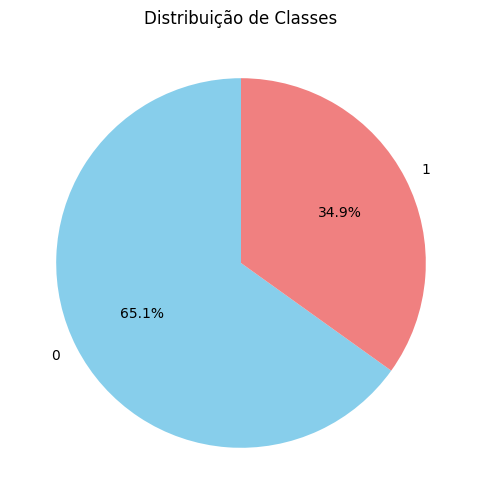

In [ ]:
#Conta quantas amostras de cada classe existem no dataset
contagem = dataframe['Outcome'].value_counts()
print("Número de amostras de cada classe:")
print(contagem)
print("\n")

# Crie um gráfico de pizza
plt.figure(figsize=(6, 6))
plt.pie(contagem, labels=contagem.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Distribuição de Classes')
plt.show()

print("\n")

Ao analisar o gráfico, observa-se que o conjunto de dados não é extenso e apresenta um desequilíbrio: dos 768 pacientes, 500 são considerados saudáveis, correspondendo a 65,10% do total, o que significa que uma das classes é representada de forma significativamente maior. Por outro lado, a parcela de pacientes com diabetes abrange apenas 34,90% dos dados, indicando que o número de pacientes diagnosticados com a doença é quase a metade do número de pacientes saudáveis.

Além disso, convém analisar o gráfico que relaciona cada feature individualmente com a variável dependente Outcome, bem como o Valor de Informação de cada feature:

In [ ]:
#Função que calcula o Valor da informação, recebe o dataframe com todos os dados, qual a feature a ser calculada e o número de intervalos/bins
def calcularIV(df, feature,n):
  #Define o tamanho de cada bin
  hist_range = (min(dataframe[feature]), max(dataframe[feature]))

  #Calcula o maior e o menor valor encontrado para essa feature
  tamanho_intervalo=(hist_range[1]-hist_range[0])/n

  #Calcula o total de amostras com Outcome=0 e o total de amostras com Outcome=1
  total_amostras=df.shape[0]
  total_positivos=df['Outcome'].sum()
  total_negativos=total_amostras-total_positivos

  #Vetor que armazena o iv de cada bin/intervalo
  iv_vetor=[]

  #Para cada intervalo/bin
  for i in range(n):
    #Define as amostras do intervalo
    bin_df = df.loc[(df[feature] >= hist_range[0]+i*tamanho_intervalo) & (df[feature] <= hist_range[0]+(i+1)*tamanho_intervalo)]

    #Calcula o número de amostras com Outcome=0 e número de amostras com Outcome=1 no intervalo
    parcial_amostras=bin_df.shape[0]
    parcial_positivos=bin_df['Outcome'].sum()
    parcial_negativos=parcial_amostras-parcial_positivos

    #Calcula a razão entre positivos/negativos do intervalo com os positivos/negativos de todo o dataset
    razao_positivos=parcial_positivos/total_positivos
    razao_negativos=parcial_negativos/total_negativos

    #Se uma das razões for zero, então soma 0.5 para evitar calcular log(0) e log(infinito)
    if razao_negativos==0:
      razao_negativos+=0.5

    if razao_positivos==0:
      razao_positivos+=0.5

    #Calcula o Weight of Evidence do intervalo/bin
    woe=math.log(razao_positivos/razao_negativos)

    #Calcula o Valor da Informação do intervalo/bin
    iv=(razao_positivos-razao_negativos)*woe

    #Adiciona no vetor com IVs dos intervalos
    iv_vetor.append(iv)

  #Retorna a soma dos IVs de cada intervalo
  return sum(iv_vetor)

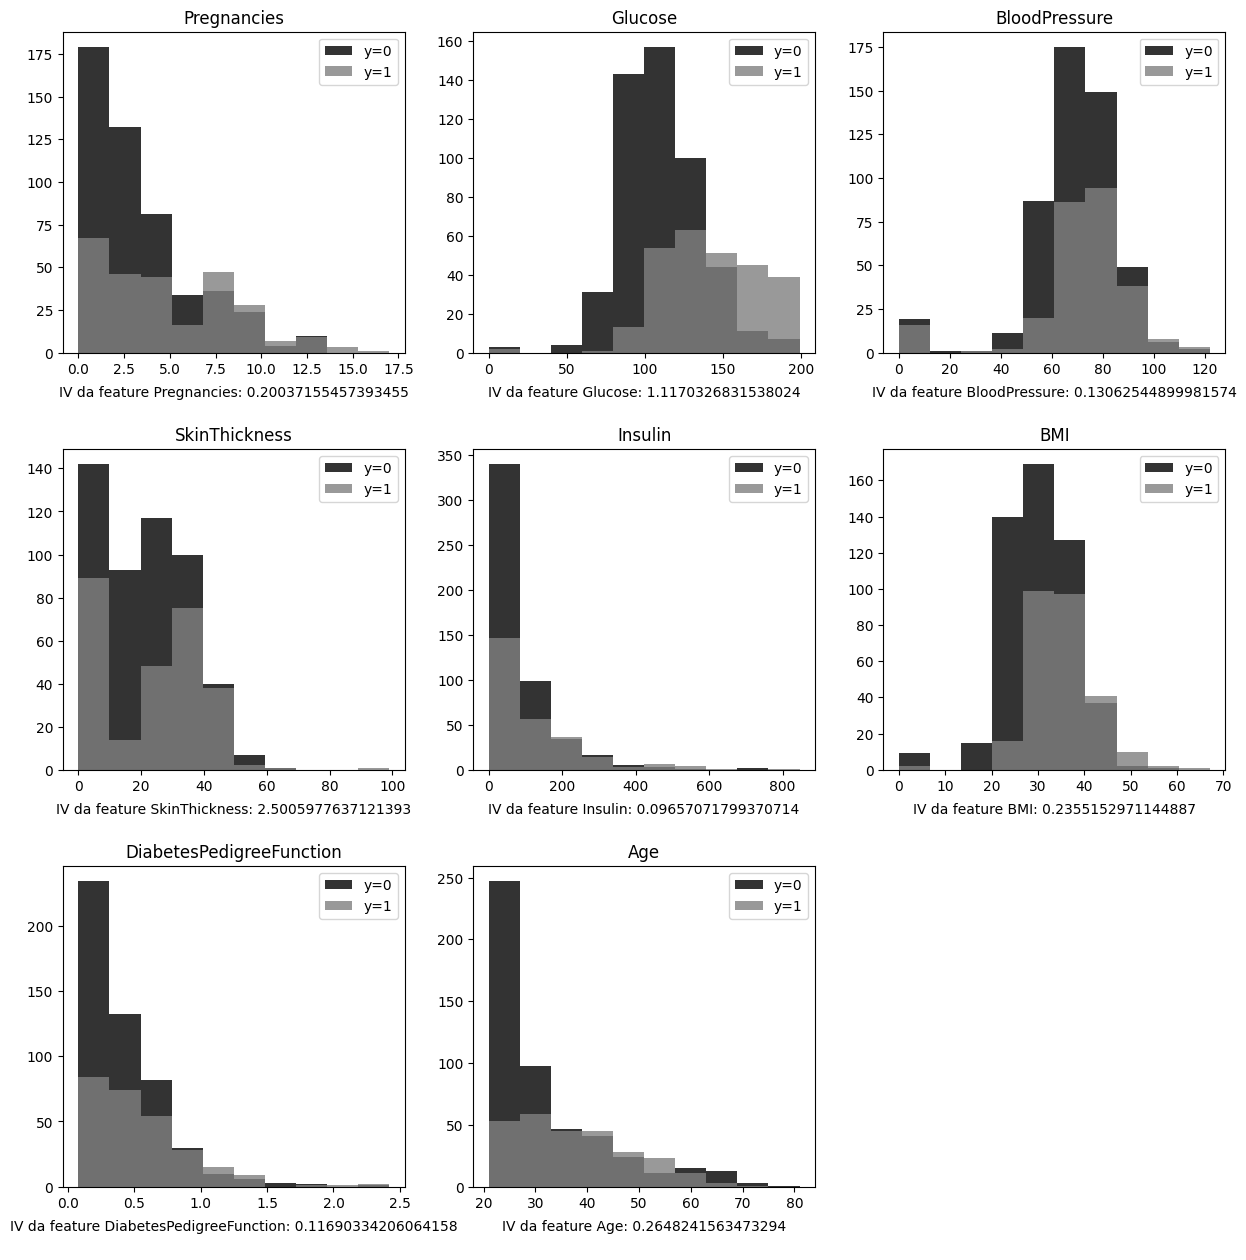

In [ ]:
#Número de gráficos por linha e coluna
num_linhas = 3
num_colunas = 3

#Variável auxiliar, usada para determinar a posição de cada gráfico
aux=0;

# Cria subplots
fig, axes = plt.subplots(num_linhas, num_colunas, figsize=(15, 15))
plt.subplots_adjust(hspace=0.3)

#Cria o histograma para cada feature
for feature in dataframe.columns[:-1]:
  #Calcula o maior e menor valor da feature
  hist_range = (min(dataframe[feature]), max(dataframe[feature]))

  #Define a posição do gráfico a ser inserido
  linha=aux//num_colunas
  coluna=aux%num_colunas

  #Cria os histogramas
  axes[linha, coluna].hist(dataframe[dataframe['Outcome'] == 0][feature], bins=10, alpha=0.8, label='y=0', range=hist_range, color='black')
  axes[linha, coluna].hist(dataframe[dataframe['Outcome'] == 1][feature], bins=10, alpha=0.8, label='y=1', range=hist_range, color='grey')

  # Define local da legenda
  axes[linha, coluna].legend(loc='upper right')

  # Adiciona título
  axes[linha, coluna].set_title(feature)

  #Adiciona texto abaixo do gráfico com o IV da feature
  axes[linha, coluna].text(0.5, -0.15, f"IV da feature {feature}: {calcularIV(dataframe,feature,4)}\n", size=10, ha='center', va='center', transform=axes[linha, coluna].transAxes)
  aux+=1
  #Define local da legenda

#Remove o último gráfico vazio
axes[-1, -1].axis('off')
#Exibe os gráficos
plt.show()

print(18*"\n")

Após a análise do Valor de Informação associado a cada característica, decidimos manter todas as características no conjunto de dados. Essa escolha fundamenta-se no fato de que, mesmo uma característica apresentando IV<0.1, os valores ainda são bastante próximos. Além disso, é relevante ressaltar que o limiar de 0.1 não constitui um valor absoluto, mas sim um critério empírico, sujeito a variações de caso a caso.

Acreditamos que, com base em nosso conhecimento, todas as características exercem influência na decisão de determinar se um paciente é ou não portador de diabetes. Vale destacar que as oito características atualmente presentes no conjunto de dados são consideradas uma quantidade moderada, não implicando em um custo computacional elevado.

# **Avaliando o Modelo**

Para avaliar a eficácia da regressão logística na resolução do problema, optamos por duas estratégias:

1. Divisão do conjunto de dados em Conjunto de Treino e Conjunto de Teste
2. Leave One Out Cross Validation

A divisão em conjunto de treino e teste consiste em dividir aleatoriamente o conjunto de dados em duas partes: uma destinada ao treinamento do modelo e outra para avaliar a capacidade de aprendizado do modelo. Tradicionalmente, o conjunto de teste costuma representar de 15% a 40% dos dados originais.

O Leave One Out Cross Validation envolve treinar n modelos, cada um com n-1 amostras, ou seja, excluindo uma amostra do conjunto de treino a cada iteração e utilizando essa amostra como caso de teste. As métricas são calculadas fazendo a média das métricas de todos os modelos.

As métricas adotadas incluíram acurácia (accuracy), precisão (precision), sensibilidade (recall) e o índice F1. Adicionalmente, optamos por apresentar a matriz de confusão, pois esta permite uma avaliação visual das capacidades e limitações do modelo.

Descrição das métricas utilizadas:

Acurácia (Accuracy): Fornece uma visão geral do desempenho do modelo, calculando a proporção de predições corretas em relação ao total de predições. Pode ser influenciada por desequilíbrios nas classes.

Precisão (Precision): Mede a proporção de predições corretas de uma classe em relação ao total de predições feitas pelo modelo para essa classe. É valiosa quando o foco está em evitar falsos positivos e falsos negativos.

Sensibilidade (Recall): Mede a proporção de predições corretas em relação ao total de amostras de uma classe.Crucial para identificar a dificuldade que o modelo possui para identificar uma classe

Índice F1 (F1 Score): O índice F1 é uma métrica que combina precisão e sensibilidade, fornecendo uma medida balanceada. É particularmente útil em situações de desequilíbrio entre as classes.

# **Divisão em Conjunto de Teste e Conjunto de Treino**

Divisão do conjunto de dados: Optamos por alocar 20% dos dados originais no conjunto de teste. Adicionalmente, fixamos uma semente para assegurar a consistência na geração dos dados, garantindo reprodutibilidade durante a execução do trabalho.

In [ ]:
#Adiciona uma coluna com constantes iguais a 1, necessário para calcular o termo de receptação/termo independente no cálculo do componente sistemático
dataframe=sm.add_constant(dataframe)

#X é o dataset sem a coluna Outcome
X=dataframe.drop("Outcome",axis=1)

#y é apenas a coluna Outcome do dataset
y=dataframe['Outcome']

#Faz a divisão do conjunto de dados, optamos por usar 20% dos dados para validar o modelo
Xtrain, Xtest, ytrain, ytest = train_test_split (X, y, test_size=0.2, random_state=42)

In [ ]:
Xtrain

,const,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
60,1.0,2,84,0,0,0,0.0,0.304,21
618,1.0,9,112,82,24,0,28.2,1.282,50
346,1.0,1,139,46,19,83,28.7,0.654,22
294,1.0,0,161,50,0,0,21.9,0.254,65
231,1.0,6,134,80,37,370,46.2,0.238,46
...,...,...,...,...,...,...,...,...,...
71,1.0,5,139,64,35,140,28.6,0.411,26
106,1.0,1,96,122,0,0,22.4,0.207,27
270,1.0,10,101,86,37,0,45.6,1.136,38
435,1.0,0,141,0,0,0,42.4,0.205,29


In [ ]:
ytrain

60     0
618    1
346    0
294    0
231    1
      ..
71     0
106    0
270    1
435    1
102    0
Name: Outcome, Length: 614, dtype: int64

In [ ]:
Xtest

,const,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
668,1.0,6,98,58,33,190,34.0,0.430,43
324,1.0,2,112,75,32,0,35.7,0.148,21
624,1.0,2,108,64,0,0,30.8,0.158,21
690,1.0,8,107,80,0,0,24.6,0.856,34
473,1.0,7,136,90,0,0,29.9,0.210,50
...,...,...,...,...,...,...,...,...,...
355,1.0,9,165,88,0,0,30.4,0.302,49
534,1.0,1,77,56,30,56,33.3,1.251,24
344,1.0,8,95,72,0,0,36.8,0.485,57
296,1.0,2,146,70,38,360,28.0,0.337,29


In [ ]:
ytest

668    0
324    0
624    0
690    0
473    0
      ..
355    1
534    0
344    0
296    1
462    0
Name: Outcome, Length: 154, dtype: int64

Treinando o modelo com os casos de teste:

In [ ]:
modelo_logit = sm.Logit(ytrain, Xtrain)
resultado_logit = modelo_logit.fit()
print(resultado_logit.summary())

Optimization terminated successfully.
         Current function value: 0.467835
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Mon, 13 Nov 2023   Pseudo R-squ.:                  0.2752
Time:                        12:56:07   Log-Likelihood:                -287.25
converged:                       True   LL-Null:                       -396.34
Covariance Type:            nonrobust   LLR p-value:                 9.311e-43
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -9.0359      0.837    -10.802      0.000     -10.675

Da tabela acima, destaco que o modelo convergiu com 6 iterações e também os valores dos coeficientes usados para calcular o Componente Sistemático.

Agora, é necessário executar os casos de teste e avaliar o desempenho do modelo. Vale a pena destacar que o modelo treinado calcula apenas o Componente Sistemático e determina a probabilidade por meio da função Logit. Ainda é preciso calcular o Componente Aleatório, o qual utiliza a probabilidade obtida para gerar o valor da variável resposta, seguindo uma distribuição de Bernoulli.

Uma prática comum é desconsiderar o Componente Aleatório e, se a probabilidade for inferior a 0.5, definir a variável resposta como 0; caso contrário, atribuir o valor 1. Essa abordagem demonstrou métricas superiores nos testes realizados, entretanto, optamos por manter o Componente Aleatório, pois este está mais alinhado com o escopo discutido neste trabalho.

In [ ]:
#Calcula as probabilidades/saída dos casos de teste
ypred = resultado_logit.predict(Xtest)

#Para cada saída do modelo
for i in range(len(ypred)):
    #Armazena a saída em uma variável p
    p=ypred.iloc(0)[i]

    #Define a i-ésima saída como uma escolha entre 0 e 1 com probabilidade 1-p e p respectivamente
    ypred.iloc(0)[i]=np.random.choice([0, 1], p=[1-p, p])

Exibindo as métricas obtidas pelo modelo. É importante destacar que as métricas podem variar de execução em execução pois há aleatoriedade envolvida tanto na divisão dos dados em casos de teste e treino quanto no Componente Aleatório do GLM

Acurácia: 0.7143
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.80      0.75      0.77        99
           1       0.59      0.65      0.62        55

    accuracy                           0.71       154
   macro avg       0.69      0.70      0.70       154
weighted avg       0.72      0.71      0.72       154



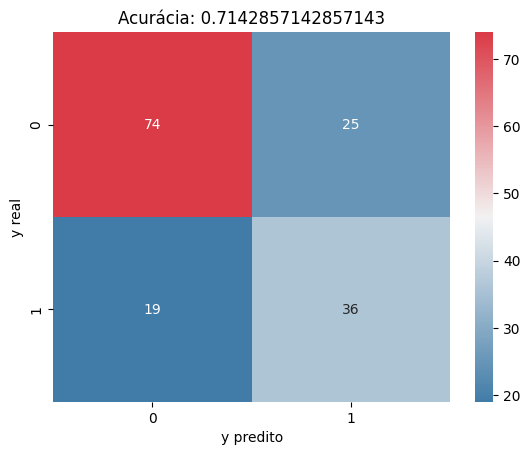

In [ ]:
#Calcula a acurácia do modelo
accuracy = accuracy_score(ytest, ypred)

# Imprimir a acurácia e outras métricas
print(f'Acurácia: {accuracy:.4f}')
print('Relatório de Classificação:')
print(classification_report(ytest, ypred))

#Calcula a matriz de confusão
cm = confusion_matrix(ytest, ypred)
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(cm, cmap=cmap,annot=True, fmt=".0f")

#Exibe a matriz de confusão
plt.xlabel('y predito')
plt.ylabel('y real')
plt.title(f'Acurácia: {accuracy}')
plt.show()

print(45*"\n")

Ao analisarmos as métricas apresentadas, destacamos os seguintes pontos: a acurácia variou entre 65% e 75%. Acreditamos que essa variação ocorre devido ao tamanho reduzido do conjunto de dados. Consequentemente, quando o Componente Aleatório altera a classificação de alguns pontos, essas mudanças, mesmo sendo pontuais, representam uma significativa porcentagem do conjunto de dados. Além disso, observou-se certa dificuldade do modelo em classificar corretamente os casos em que y=1. Esta dificuldade pode ser atribuída ao desbalanceamento do conjunto de dados, que conta com poucas instâncias em que y=1, dificultando o treinamento eficaz do modelo para essa classe.

# **Leave One Out**

Para avaliar o modelo usando Leave One Out, usamos a função KFold para dividir o modelo em 768 folds. Para calcular as métricas, contabilizamos o número de falsos positivos, falsos negativos, verdadeiros positivos e verdadeiros negativos. Usamos esses valores para calcular as métricas Precision, Recall e F1. A Acurácia é obtida fazendo a média de todas as acurácias. Da mesma forma que no caso anterior, é necessário usar a probabilidade obtida para calcular o Componente Aleatório

Acurácia média: 0.7044
precicion 0: 0.7746478873239436
precicion 1: 0.5756457564575646
recall 0: 0.77
recall 1: 0.582089552238806
f1 0: 0.7723169508525577
f1 1: 0.5788497217068646


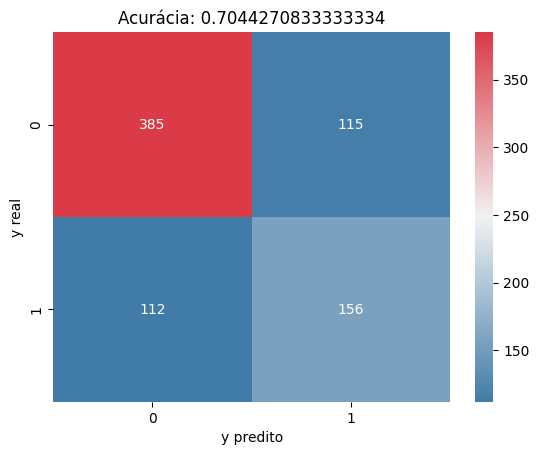

In [ ]:
# Configurar a validação cruzada com 768 folds
kf = KFold(n_splits=768, shuffle=True, random_state=42)

# Listas para armazenar métricas de desempenho em cada fold
accuracy_list = []
falsos_positivos=0
falsos_negativos=0
verdadeiros_positivos=0
verdadeiros_negativos=0

# Iterar sobre os folds
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Ajustar o modelo aos dados de treino
    model = sm.Logit(y_train, X_train)
    result = model.fit(disp=0)  # Ajustar o modelo com disp=0 para suprimir a saída

    # Prever as probabilidades no conjunto de teste
    y_pred= result.predict(X_test)

    # Converter as probabilidades em classes (0 ou 1) usando um distribuição de Bernoulli
    for i in range(len(y_pred)):
      p=y_pred.iloc(0)[i]
      y_pred.iloc(0)[i]=np.random.choice([0, 1], p=[1-p, p])

    # Calcular a precisão e armazenar na lista
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)

    #Contabiliza se o modelo acertou ou não
    if y_test.iloc(0)[0]== 0 and y_pred.iloc(0)[0]==0.0:
      verdadeiros_negativos+=1

    if y_test.iloc(0)[0]== 1 and y_pred.iloc(0)[0]==1.0:
      verdadeiros_positivos+=1

    if y_test.iloc(0)[0]== 0 and y_pred.iloc(0)[0]==1.0:
      falsos_positivos+=1

    if y_test.iloc(0)[0]== 1 and y_pred.iloc(0)[0]==0.0:
      falsos_negativos+=1

# Imprimir a acurácia média sobre todos os folds
print(f'Acurácia média: {np.mean(accuracy_list):.4f}')

#Calcula a precisão das duas classes
precision_1=verdadeiros_positivos/(verdadeiros_positivos+falsos_positivos)
precision_0=verdadeiros_negativos/(verdadeiros_negativos+falsos_negativos)

#Calcula o recall das duas classes
recall_1=verdadeiros_positivos/(verdadeiros_positivos+falsos_negativos)
recall_0=verdadeiros_negativos/(verdadeiros_negativos+falsos_positivos)

#Calcula a F1 das duas classes
f1_1=(2*precision_1*recall_1)/(precision_1+recall_1)
f1_0=(2*precision_0*recall_0)/(precision_0+recall_0)

#Exibe os resultados obtidos
print(f'precicion 0: {precision_0}')
print(f'precicion 1: {precision_1}')

print(f'recall 0: {recall_0}')
print(f'recall 1: {recall_1}')

print(f'f1 0: {f1_0}')
print(f'f1 1: {f1_1}')

#Calcula a matriz de confusão
cm = [[verdadeiros_negativos, falsos_positivos],[falsos_negativos, verdadeiros_positivos]]
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(cm, cmap=cmap,annot=True, fmt=".0f")

#Exibe a matriz de confusão
plt.xlabel('y predito')
plt.ylabel('y real')
plt.title(f'Acurácia: {np.mean(accuracy_list)}')
plt.show()

print(28*"\n")

Pode-se observar que a validação utilizando Leave One Out apresenta resultados similares aos obtidos anteriormente. As métricas ainda não são consistentes devido à aleatoriedade do Componente Aleatório, mas variam menos. O modelo persiste em demonstrar certa dificuldade em classificar corretamente a classe 1, conforme indicam as métricas recall 1 e precision 1. Acreditamos que esta dificuldade persiste pelo mesmo motivo mencionado anteriormente: o desbalanceamento do conjunto de dados.

# **Treino com todos os Dados**

Dado o sucesso obtido ao avaliar a adequação da Regressão Logística aos dados, podemos proceder treinando um modelo com todos os dados disponíveis e avaliando suas métricas em comparação com as saídas esperadas. É importante ressaltar que tal abordagem pode resultar em uma avaliação tendenciosa, no entanto, já verificamos que a Regressão Logística demonstrou ser uma solução eficaz para o problema, empregando técnicas como a divisão do conjunto de treino e teste, assim como o Leave One Out.

Acurácia: 0.7070
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       500
           1       0.58      0.61      0.59       268

    accuracy                           0.71       768
   macro avg       0.68      0.68      0.68       768
weighted avg       0.71      0.71      0.71       768



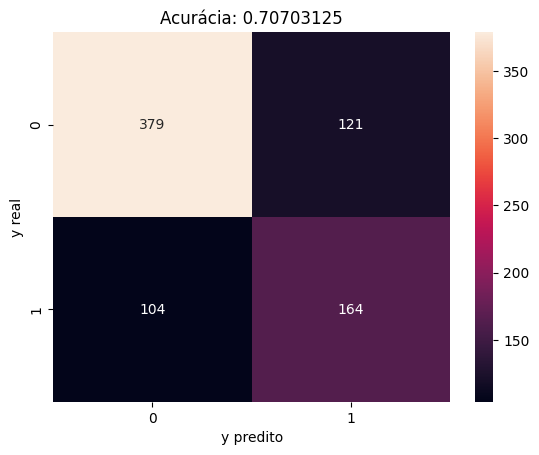

In [ ]:
#Treina o modelo com todos os dados
model = sm.Logit(y, X)
resultado_logit = model.fit(disp=0)

#Calcula as predições do modelo e converte as probabilidades em uma classe 0 ou 1 usando distribuição de Bernoulli
ypred = resultado_logit.predict(X)
for i in range(len(ypred)):
    p=ypred.iloc(0)[i]
    ypred.iloc(0)[i]=np.random.choice([0, 1], p=[1-p, p])

#Calcula a acurácia do modelo
accuracy = accuracy_score(y, ypred)

# Imprimir a acurácia e outras métricas
print(f'Acurácia: {accuracy:.4f}')
print('Relatório de Classificação:')
print(classification_report(y, ypred))

#Calcula a matriz de confusão
cm = confusion_matrix(y, ypred)
sns.heatmap(cm, annot=True, fmt=".0f")

#Exibe a matriz de confusão
plt.xlabel('y predito')
plt.ylabel('y real')
plt.title(f'Acurácia: {accuracy}')
plt.show()

print("\n")

Pode-se observar resultados similares aos obtidos anteriormente. As métricas ainda não são consistentes devido à aleatoriedade do Componente Aleatório, mas variam menos. O modelo persiste em demonstrar certa dificuldade em classificar corretamente a classe 1, conforme indicam as métricas recall 1 e precision 1. Acreditamos que esta dificuldade persiste pelo mesmo motivo mencionado anteriormente: o desbalanceamento do conjunto de dados.

# **Conclusão**

Consideramos a execução do trabalho satisfatória. O conjunto de dados, embora simplificado com poucas features, apresenta desafios poispossui poucas amostras e desbalanceamento. O modelo mostrou um bom desempenho, contudo, enquanto um classificador na área de saúde, revelou limitações na identificação confiável de pacientes diabéticos, notadamente em relação aos casos de falsos negativos, reconhecendo a relevância crítica destes em contextos de saúde. De forma geral, a aplicação prática dos conceitos discutidos em sala de aula proporcionou uma compreensão mais aprofundada das métricas, técnicas de validação e aprimorou nossa habilidade de avaliar GLMs.